# Class 22: Intro to Machine Learning

Plan for today:
- Creating confidence intervals
- Introduction to Machine Learning


In [1]:
import YData

# YData.download.download_class_code(22)   # get class code    
# YData.download.download_class_code(22, TRUE) # get the code with the answers 


In [2]:
## If you are using Google Colabs, you should install the YData packages and mount the your google drive by uncommenting and running the code below.

# !pip install https://github.com/emeyers/YData_package/tarball/master
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from urllib.request import urlopen

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Using hypothesis tests to generate confidence intervals

There are several methods we that can be used to calculate confidence intervals, including using a computational method called the "bootstrap" and using "parametric methods" that involve using probability distributions. If you take a traditional introductory statistics class you will learn some of these methods.

Below we use a less conventional method to calculate confidence intervals by looking at all parameters values that a hypothesis test fails to reject (at the p-value < 0.05 level). As you will see, the method gives similar results to other methods, although it requires a bit more computation time.

As an example, let's create a confidence interval for the population proportion of movies $\pi$ that pass the Bechdel test. As is the case for all confidence intervals, this confidence interval gives a range of plausible values that likely contains the true population proportion $\pi$.


In [4]:
# To start, let's use a function that generates a statistic p-hat that is consistent with a particular population parameter value pi

def generate_prop_bechdel(n, null_prop):
    
    random_sample = np.random.rand(n) <= null_prop
    return np.mean(random_sample)


# Call the function to get one p-value consistent with H0: pi = .5

generate_prop_bechdel(1794, .5)


np.float64(0.5217391304347826)

In [5]:
# The function below calculates a p-value for the Bechdel data based on a particular pi value that is specified in a null hypothesis.
# (i.e., it is a function that encapsulates the hypothesis test you ran in class 20).


def get_Bechdel_pvalue(null_hypothesis_pi, plot_null_dist = False):
    
    
    # Step 2: The observed p-hat value
    prop_passed = 803/1794
    
    
    # Step 3: Generate the null distribution 
    null_dist = []
    
    for i in range(10000):    
        null_dist.append(generate_prop_bechdel(1794, null_hypothesis_pi))
    
    
    # Step 4: Calculate a "two-tailed" p-value which is the proportion of statistcs 
    # more extreme than the observed statistic
    
    statistic_deviation = np.abs(null_hypothesis_pi - prop_passed)
    
    pval_left = np.mean(np.array(null_dist) <= null_hypothesis_pi - statistic_deviation)
    pval_right = np.mean(np.array(null_dist) >= null_hypothesis_pi + statistic_deviation)
    
    p_value = pval_left + pval_right

    
    # plot the null distribution and lines indicating values more extreme than the observed statistic 
    if plot_null_dist:
        
        plt.hist(null_dist, edgecolor = "black", bins = 30);
        plt.axvline(null_hypothesis_pi - statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi + statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi, color = "yellow");

        
        plt.title("Pi-null is: " + str(null_hypothesis_pi) + "      "  +
                  "p-value is: " + str(round(p_value, 5)))
      
    # return the p-value
    return p_value
    


np.float64(0.8557)

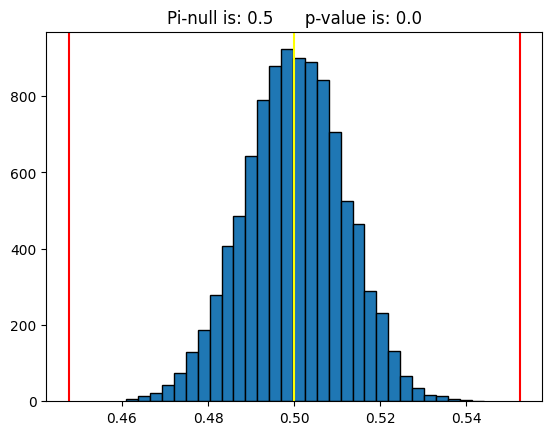

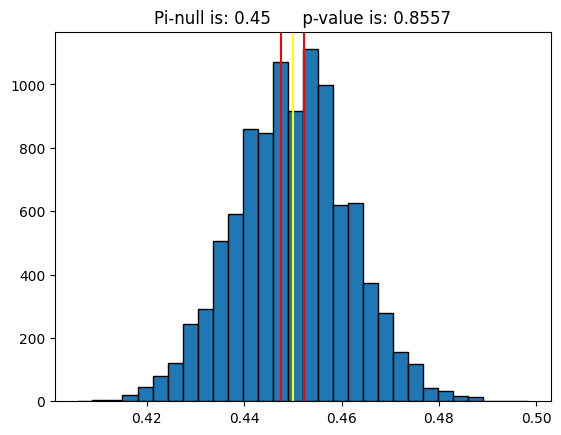

In [6]:
# test the function with the value H0: pi = .5  (as we did in class 20)
get_Bechdel_pvalue(.5, True)


# test the function with the value H0: pi = .45
plt.figure()
get_Bechdel_pvalue(.45, True)

In [7]:
# create a range range of H0: pi = x  values

possible_null_pis = np.round(np.arange(.4, .5, .005), 5)

possible_null_pis    


array([0.4  , 0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 ,
       0.445, 0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485,
       0.49 , 0.495])

In [8]:
%%time

# get the p-value for a range of H0: pi = x  values

pvalues = []

for null_pi in possible_null_pis:
    
    curr_pvalue = get_Bechdel_pvalue(null_pi)
    
    pvalues.append(curr_pvalue)



CPU times: user 2.49 s, sys: 0 ns, total: 2.49 s
Wall time: 2.5 s


In [9]:
# view the p-values 
# convention calls a p-value < 0.05 is "statistically significant" indicating a pi imcompatible with the null hypothesis
# our confidence interval is all pi values that are not statistically significant (i.e., pi values that are consistent with particular H0)

pvalue_df = pd.DataFrame({"pi": possible_null_pis, 
                          "p-values": pvalues,
                          "non-significant": np.array(pvalues) > .05})

pvalue_df


,pi,p-values,non-significant
0,0.400,0.0000,False
1,0.405,0.0002,False
2,0.410,0.0013,False
3,0.415,0.0049,False
4,0.420,0.0215,False
5,0.425,0.0478,False
6,0.430,0.1362,True
7,0.435,0.2861,True
8,0.440,0.5253,True
9,0.445,0.8269,True


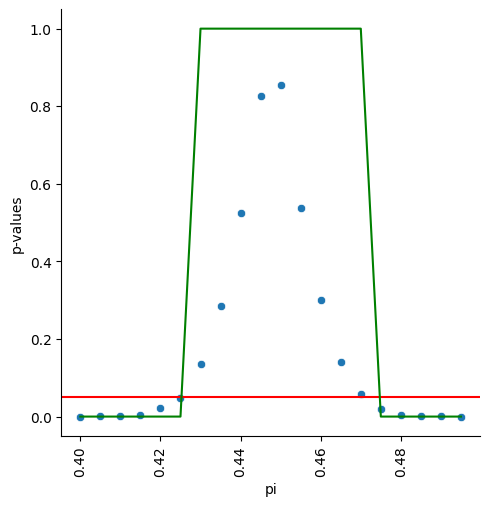

In [10]:
# plot p-values as as function of H0 pi's

sns.relplot(pvalue_df, x = 'pi', y = 'p-values');
plt.xticks(rotation=90);
plt.axhline(.05, color = "red");

plt.plot(pvalue_df['pi'], pvalue_df['non-significant'], color = "green");


In [11]:
# Get all plausible Pi values
fail_to_reject_pis = possible_null_pis[np.array(pvalues) >= .05]

fail_to_reject_pis

array([0.43 , 0.435, 0.44 , 0.445, 0.45 , 0.455, 0.46 , 0.465, 0.47 ])

In [12]:
# get the CI as the max and min plausible pi values 

(min(fail_to_reject_pis), max(fail_to_reject_pis))


(np.float64(0.43), np.float64(0.47))

In [13]:
# using the statsmodels package to compute a confidence interval for a proportion

import statsmodels.api as sm

ci_low, ci_upp = sm.stats.proportion_confint(803, 1794, alpha=0.05, method='normal')
(round(ci_low, 3), round(ci_upp, 3))


(0.425, 0.471)

## 2. Intro to Machine Learning:  Features (X) and labels (y)

In supervised machine learning, we use a computer algorithm called a "pattern classifier" to learn relationships between a set of features X, and a label y. When the classifier is given new examples X, it can then make new predictions y. 


In [14]:
penguins = sns.load_dataset("penguins")

penguins = penguins.dropna()

penguins = penguins.sample(frac = 1)

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
234,Gentoo,Biscoe,45.8,14.6,210.0,4200.0,Female
309,Gentoo,Biscoe,52.1,17.0,230.0,5550.0,Male
217,Chinstrap,Dream,49.6,18.2,193.0,3775.0,Male
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,Male
209,Chinstrap,Dream,49.3,19.9,203.0,4050.0,Male


In [15]:
# Let's explore how many different members there are of each species in our data set? 

species_counts = penguins.groupby("species").agg(count = ('island', 'count'))

species_counts


,count
species,
Adelie,146
Chinstrap,68
Gentoo,119


#### Questions: 

1. If we had to guess the species of the penguin without knowing any of the penguin's features, species of penguin should we guess? 
A: Always guess Adelie


2. If we were to following the optimal guessing strategy, what percent of our guess would be correct (i.e., what would our classification accuracy be)? 


In [16]:
species_counts['count']/sum(species_counts['count'])

species
Adelie       0.438438
Chinstrap    0.204204
Gentoo       0.357357
Name: count, dtype: float64

To begin the classification process, let's store the features (X) and the labels (y) in separate names called `X_penguin_features` and `y_penguin_labels` respectively. 

In [17]:
# get the features and the labels

X_penguin_features = penguins[['bill_length_mm', 
                               'bill_depth_mm',
                               'flipper_length_mm', 
                               'body_mass_g']]

y_penguin_labels = penguins['species']


## 3. k-Nearest Neighbors classifier


To explore classification, let's use a k-Nearest Neighbors classifier to predict the species of a penguin based on particular features the penguin has such as the penguin's bill length and body mass. 

Let's construct a K-Nearest Neighbor classifier (KNN) using 5 neighbors for predictions (i.e., k = 5 so we are using a 5-Nearest Neighbor classifier). 

We can do this using the `KNeighborsClassifier(n_neighbors = )` function.  


In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Construct a classifier a 5 nearest neighbor classifier
knn = KNeighborsClassifier(n_neighbors = 5) 


Let's now train the classifier (the KNN classifier just stores the data during training)


In [19]:
# “train” the classifier (which for a KNN classifier just involves memorizing the training data)

knn.fit(X_penguin_features, y_penguin_labels) 


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Let's now use the classifier to make predictions

In [20]:
# make predictions
penguin_preditions = knn.predict(X_penguin_features)

penguin_preditions[0:10]

array(['Gentoo', 'Gentoo', 'Chinstrap', 'Adelie', 'Chinstrap', 'Gentoo',
       'Adelie', 'Gentoo', 'Adelie', 'Chinstrap'], dtype=object)

Let's get the prediction (classificaton accuracy) which is the proportion of predictions that are correct

In [21]:
# get the classification accuracy
np.mean(penguin_preditions == y_penguin_labels)

np.float64(0.8378378378378378)

Let's repeat our analysis with k = 1 to see what happens...

In [22]:
# What happens if k = 1?

# construct a classifier
knn = KNeighborsClassifier(n_neighbors = 1) 

# “train” the classifier (which for a KNN classifier just involves memorizing the training data)
knn.fit(X_penguin_features, y_penguin_labels) 

# make predictions
penguin_preditions = knn.predict(X_penguin_features)

# get classification accuracy
np.mean(penguin_preditions == y_penguin_labels)

np.float64(1.0)

Do we believe we have a perfect classifier???


## 4. Cross-validation

To avoid over-fitting, we need to split our data into a training and test set. 

The classifier "learns" the relationship between features (X) and labels (y) on the **training set**.

The classifier makes predictions on the features (X) of the **test set**. 

We compare the classifier's predictions on the test features (X) to the actual labels y, to get a more accuracy assessment of the **classification accuracy**.


Let's try this now...



In [23]:
# manually create a training with 250 examples, and a test set that has the rest of the data

X_train_manual = X_penguin_features.iloc[0:250, :]
y_train_manual = y_penguin_labels.iloc[0:250]

X_test_manual = X_penguin_features.iloc[250:, :]
y_test_manual = y_penguin_labels.iloc[250:]


print(X_train_manual.shape)
print(X_test_manual.shape)


(250, 4)
(83, 4)


In [24]:
from sklearn.model_selection import train_test_split

# split data into a training and test set

X_train, X_test, y_train, y_test = train_test_split(X_penguin_features,  
                                                    y_penguin_labels, 
                                                    random_state = 0)

print(X_train.shape)
print(X_test.shape)

X_train.head(3)


(249, 4)
(84, 4)


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
334,46.2,14.1,217.0,4375.0
196,50.9,17.9,196.0,3675.0
63,41.1,18.2,192.0,4050.0


In [25]:
from sklearn.neighbors import KNeighborsClassifier


# construct a classifier
knn = KNeighborsClassifier(n_neighbors = 1) 

# “train” the classifier (which for a KNN classifier just involves memorizing the training data)
knn.fit(X_train_manual, y_train_manual) 



,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [26]:
# get the predictions

penguin_preditions = knn.predict(X_test_manual)

penguin_preditions

array(['Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie', 'Adelie',
       'Gentoo', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie', 'Gentoo',
       'Adelie', 'Chinstrap', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie',
       'Chinstrap', 'Adelie', 'Gentoo', 'Chinstrap', 'Adelie', 'Adelie',
       'Adelie', 'Adelie', 'Gentoo', 'Chinstrap', 'Adelie', 'Chinstrap',
       'Adelie', 'Chinstrap', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo',
       'Adelie', 'Adelie', 'Adelie', 'Gentoo', 'Adelie', 'Chinstrap',
       'Gentoo', 'Adelie', 'Adelie', 'Adelie', 'Chinstrap', 'Chinstrap',
       'Gentoo', 'Gentoo', 'Adelie', 'Adelie', 'Adelie', 'Gentoo',
       'Adelie', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo', 'Adelie',
       'Chinstrap', 'Gentoo', 'Chinstrap', 'Gentoo', 'Gentoo', 'Adelie',
       'Gentoo', 'Adelie', 'Gentoo', 'Adelie', 'Adelie', 'Chinstrap',
       'Gentoo', 'Adelie', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie',
       'Gentoo', 'Gentoo', 'Adelie', 'Adelie', 'Gentoo'], dtype=object)

In [27]:
# Get the prediction accuracy 

np.mean(penguin_preditions == y_test_manual)



np.float64(0.891566265060241)

In [28]:
# Test the classifier on the test set using the .score() method

knn.score(X_test_manual, y_test_manual) # prediction accuracy on the test set

0.891566265060241

In [29]:
# What happens if we test the classifier on the training set? 

knn.score(X_train_manual, y_train_manual) # prediction accuracy on the training set



1.0

### K-fold cross-validation

In k-fold cross-validation we split our data into k-parts (note, the k here has no relation to the k in k-Nearest Neighbor - it is just that k is a frequent letter to use in math to denote integer values).  

To run a k-fold cross-validation analysis, we train the classifier on k-1 parts of the data and test it on the remaining part. We repeat this process k times to get k classification accuracies. We then take the average of these results as our estimate of our overall classification accuracy. 

We can use the scikit-learn `cross_val_score()` to easily do this...


In [30]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 1) # construct knn classifier

# do 5-fold cross-validation
scores = cross_val_score(knn, X_penguin_features,  y_penguin_labels, cv = 5)

print(scores)

print(scores.mean())

[0.85074627 0.89552239 0.88059701 0.8030303  0.87878788]
0.8617367706919946


## 5. Other classifiers

Many other types of classifiers that have been created. Scikit-learn makes it very easy to try out a range of classifiers. 

Let's explore the Support Vector Machine, and Random Forest Classifier on our penguin data...

In [31]:
# Suppress ConvergenceWarning - please ignore this code 
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Try a support vector machine (SVM)

from sklearn.svm import LinearSVC

svm = LinearSVC()   # max_iter=10000

scores = cross_val_score(svm, X_penguin_features,  y_penguin_labels, cv = 5)

print(scores.mean())

0.9879240162822253


In [32]:
# Try a random forest

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

scores = cross_val_score(random_forest, X_penguin_features,  y_penguin_labels, cv = 5)

print(scores.mean())

0.975893260967888


Next class, buliding a KNN classifier ourselves...

In [33]:
%%capture

# You can run this code to covert this Jupyter notebook into a pdf
!quarto render class_22_answers.ipynb --cache-refresh --to pdf 